<a href="https://colab.research.google.com/github/TheodoredaCunha/Kdot-Lyrics-TopicModelling/blob/main/Rap_Lyrics_TopicModelling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=37d4b691cccde3ba642677f36800ee1f80fecee5ea0a4bae92d4fa0705e47ba4
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Dataset Preprocessing and Visualization**

In [ ]:
from tkinter.constants import X
raw_data = pd.read_csv('updated_rappers.csv')
raw_data.head()

,Unnamed: 0,artist,song,lyric,next lyric
0,0,Fetty Wap,Trap Queen,rgf productions,remy boyz yahah
1,0,Fetty Wap,Trap Queen,remy boyz yahah,1738 ayy
2,0,Fetty Wap,Trap Queen,1738 ayy,im like hey whats up hello
3,0,Fetty Wap,Trap Queen,im like hey whats up hello,seen yo pretty ass soon as you came in the door
4,0,Fetty Wap,Trap Queen,seen yo pretty ass soon as you came in the door,i just wanna chill got a sack for us to roll


In [ ]:
artists = [
    "Kendrick Lamar", "Tupac Shakur", "The Notorious B.I.G", "Big Sean", "A$AP Rocky",
    "Drake", "J. Cole", "Eminem", "Snoop Dogg", "Jay Rock", "Nicki Minaj", "De La Soul",
    "Ab-Soul", "Danny Brown", "XXXTentacion", "Nas", "Jay-Z", "Lil Wayne", "Future",
    "Killer Mike", "Twista", "Travis Scott", "Logic", "Childish Gambino", "Kanye West",
    "Lil Uzi Vert", "Mac Miller", "Lil Yachty", "Migos", "Tyler, The Creator", "Joey Bada$$",
    "Run The Jewels", "Wiz Khalifa", "Rick Ross", "Pusha T", "Freddie Gibbs", "Schoolboy Q",
    "Big K.R.I.T.", "A$AP Ferg", "Meek Mill", "Vince Staples", "Busta Rhymes", "2 Chainz",
    "Young Thug", "Lil Durk", "Post Malone", "YBN Cordae", "Cardi B"
]

# Drop the "next lyric" column
data = raw_data.drop(columns=["next lyric"], errors="ignore")  # Ignore if column doesn't exist

# Combine lyrics for the same song while keeping the artist column
data = data.groupby("song", as_index=False).agg({"artist": "first", "lyric": " ".join})

# Filter data to include only the artists in the specified list
data = data[data['artist'].isin(artists)]

# Display the resulting data
data.head()

,song,artist,lyric
5,#HottestMC,Danny Brown,fuck any rapper rappin if the nigga aint dappi...
6,#ImSippinTeaInYoHood,XXXTentacion,hehe yeah you know im posted in the booth with...
7,#LTM,Ab-Soul,i brought you something close to me and left w...
10,#PROUDCATOWNER #IHATERAPPERS #IEATPUSSY,XXXTentacion,oh my god ronny oh she ratchet i might smash h...
41,0 to 100 (Remix),Meek Mill,rat nigga got my chain snatched and he didnt e...


In [ ]:
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Load the profanity list from the text file
with open("profanity-list.txt", "r") as file:
    profanity_words = set(file.read().splitlines())

# Define a set of onomatopoeia words (add more as needed)
onomatopoeia_words = {"ooh", "yeah", "uh", "whoa", "ah", "huh", "boom", "bam", "vroom", "woah", "hmm", "oohooh", "uhuh", "nanana", "ohoh", "hehe"}

# Function to remove stop words, short words, profanity, and onomatopoeia
def clean_lyrics(lyrics):
    return [word for word in lyrics
            if len(word) > 3  # Remove short words
            and word.lower() not in stop_words  # Remove stop words
            and word.lower() not in profanity_words  # Remove profanity
            and word.lower() not in onomatopoeia_words]  # Remove onomatopoeia

# Apply the function to clean lyrics
data["lyric"] = data["lyric"].apply(lambda x: clean_lyrics(x.split()))

print(len(data))
data.head()

2664


,song,artist,lyric
5,#HottestMC,Danny Brown,"[rapper, rappin, aint, dappin, show, respect, ..."
6,#ImSippinTeaInYoHood,XXXTentacion,"[know, posted, booth, boof, ronny, gotta, mood..."
7,#LTM,Ab-Soul,"[brought, something, close, left, something, h..."
10,#PROUDCATOWNER #IHATERAPPERS #IEATPUSSY,XXXTentacion,"[ronny, ratchet, might, smash, bend, backwards..."
41,0 to 100 (Remix),Meek Mill,"[chain, snatched, didnt, even, chain, back, ne..."


In [ ]:
def remove_consecutive_duplicates(text):
    return [word for i, word in enumerate(text) if i == 0 or word != text[i - 1]]

data["lyric"] = [remove_consecutive_duplicates(text) for text in data["lyric"]]


<ipython-input-64-e80474328314>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=album_counts.values, y=album_counts.index, palette="viridis")


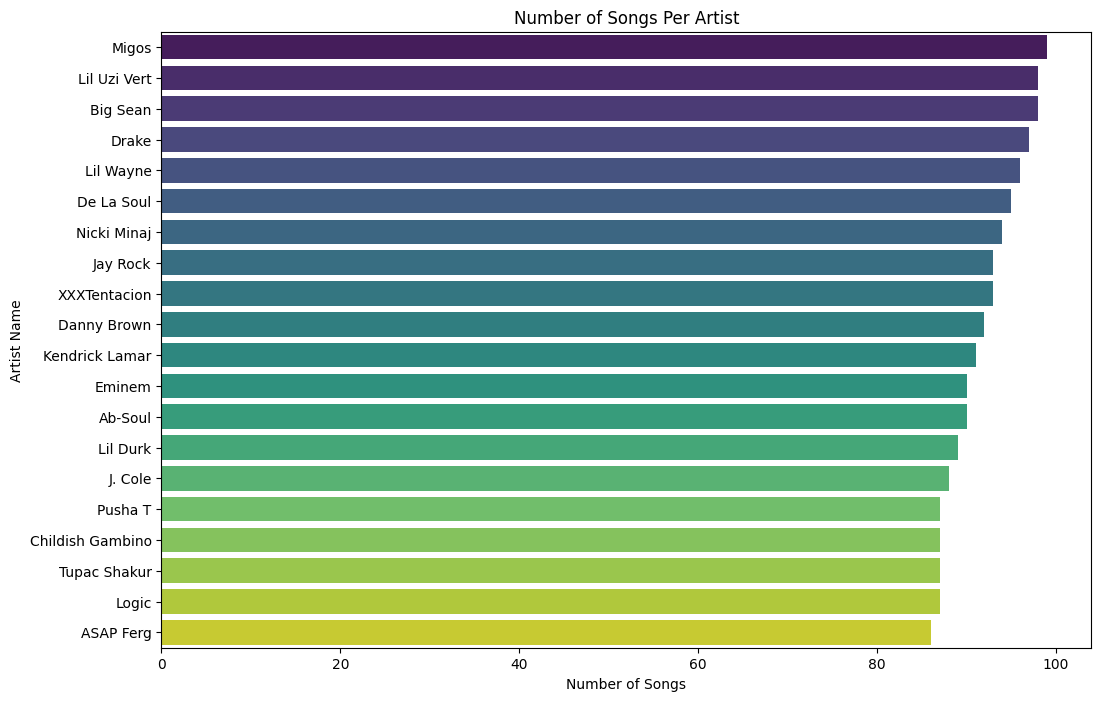

In [ ]:
# getting rid of $ for all the A$APs and Joey Bada$$
data["artist"] = data["artist"].str.replace(r"[$]", "S", regex=True)
album_counts = data['artist'].value_counts().head(20)


plt.figure(figsize=(12, 8))
sns.barplot(x=album_counts.values, y=album_counts.index, palette="viridis")

plt.xlabel("Number of Songs")
plt.ylabel("Artist Name")
plt.title("Number of Songs Per Artist")

plt.show()

In [ ]:
# Calculate average length of songs per album

data['word_count'] = data['lyric'].apply(lambda x: len(x))

# Calculate the average song length per album
avg_lyric_len = data['word_count'].mean().round(2)

print(avg_lyric_len)


287.61


# **LDA**



In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.2 MB/s eta 0:00:00


In [ ]:
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

from tqdm import tqdm

In [ ]:
# Assume 'tokenized_texts' is a list of lists of tokens (your preprocessed corpus)
bigram = Phrases(data["lyric"], min_count=5, threshold=10)  # Adjust min_count and threshold
bigram_phraser = Phraser(bigram)  # Faster processing

# Transform tokenized corpus to include bigrams
tokenized_texts = [bigram_phraser[text] for text in data["lyric"]]

In [ ]:
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_above=0.01)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]


In [ ]:
print(f"Dictionary Size: {len(dictionary)}")
print(dictionary.token2id)

Dictionary Size: 8072
{'adderall': 0, 'anorexic': 1, 'australia': 2, 'billion': 3, 'blonde': 4, 'burnt': 5, 'carry_cross': 6, 'caucasian': 7, 'century': 8, 'daniel': 9, 'diaper': 10, 'earthquake': 11, 'exit': 12, 'explanation': 13, 'findin': 14, 'heatin': 15, 'howd': 16, 'hurricane': 17, 'hybrid': 18, 'judgement': 19, 'labels': 20, 'latest': 21, 'maze': 22, 'motor': 23, 'mouths': 24, 'nature': 25, 'naughty': 26, 'perm': 27, 'poet': 28, 'prize': 29, 'realitys': 30, 'recite': 31, 'riot': 32, 'scalp': 33, 'shed_tear': 34, 'smiles': 35, 'sniffin': 36, 'speech': 37, 'sunshine': 38, 'wiped': 39, 'addin': 40, 'blade': 41, 'produced': 42, 'ronny': 43, 'spleen': 44, 'stab': 45, 'background': 46, 'benches': 47, 'bush': 48, 'confuse': 49, 'david': 50, 'dedicate': 51, 'everybody_else': 52, 'everyones': 53, 'expression': 54, 'finding': 55, 'freestyle': 56, 'george': 57, 'groovin': 58, 'haunt': 59, 'highest': 60, 'long_term': 61, 'manifest': 62, 'mentality': 63, 'murderers': 64, 'none_yall': 65, 'pr

In [ ]:
num_topics = 7
# Define number of topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

for i, topic in lda_model.print_topics():
    print(f"Topic {i}: {topic}")



Topic 0: 0.003*"comfortable" + 0.003*"scandalous" + 0.003*"better_days" + 0.002*"start_riot" + 0.002*"bottom_line" + 0.002*"keep_fallin" + 0.002*"rollies" + 0.002*"five_four" + 0.002*"since_youngin" + 0.002*"darling"
Topic 1: 0.004*"leave_lone" + 0.004*"snoop_doggy" + 0.003*"nonstop" + 0.003*"guess_whos" + 0.003*"never_loved" + 0.002*"aint_easy" + 0.002*"nick" + 0.002*"troublesome" + 0.002*"money_power" + 0.002*"doggy_dogg"
Topic 2: 0.004*"really_care" + 0.004*"twistin" + 0.003*"born_sinner" + 0.003*"money_weed" + 0.003*"turn_lights" + 0.003*"stakes_high" + 0.002*"presidents" + 0.002*"front_door" + 0.002*"wutang" + 0.002*"triple_beam"
Topic 3: 0.007*"thug_passion" + 0.003*"work_hard" + 0.003*"makin_money" + 0.003*"rearview" + 0.003*"goin_crazy" + 0.002*"thank_lord" + 0.002*"terrified" + 0.002*"beat_case" + 0.002*"goodness" + 0.002*"york_city"
Topic 4: 0.005*"started_bottom" + 0.005*"danny_brown" + 0.003*"grindin" + 0.003*"whole_team" + 0.002*"feels_good" + 0.002*"strings_attached" + 0.

In [ ]:
coherencemodel = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.7254951675889936


In [ ]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [ ]:
num_words = 10  # Number of words to display per topic

for topic_id in range(lda_model.num_topics):
    words = lda_model.show_topic(topic_id, num_words)
    top_words = ", ".join([word for word, prob in words])
    print(f"Topic {topic_id}: {top_words}")


Topic 0: comfortable, scandalous, better_days, start_riot, bottom_line, keep_fallin, rollies, five_four, since_youngin, darling
Topic 1: leave_lone, snoop_doggy, nonstop, guess_whos, never_loved, aint_easy, nick, troublesome, money_power, doggy_dogg
Topic 2: really_care, twistin, born_sinner, money_weed, turn_lights, stakes_high, presidents, front_door, wutang, triple_beam
Topic 3: thug_passion, work_hard, makin_money, rearview, goin_crazy, thank_lord, terrified, beat_case, goodness, york_city
Topic 4: started_bottom, danny_brown, grindin, whole_team, feels_good, strings_attached, stay_close, swipe, love_songs, tastes
Topic 5: donald, talk_nice, young_sinatra, steve, swank, dirt_name, trigger_finger, wont_stop, slim_shady, walks
Topic 6: world_mine, things_change, slim_shady, play_games, hannah_montana, carry_cross, feels_good, currency, wont_hold, mmmm


In [ ]:
# Assign dominant topic
def get_dominant_topic(text):
    bow_vector = dictionary.doc2bow(text)
    topic_probs = lda_model.get_document_topics(bow_vector)

    if topic_probs:  # Ensure it's not empty
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]  # Get topic with highest probability
        return dominant_topic
    return None  # Handle cases where no topic is found

# Apply the function to get dominant topic
data["dominant_topic"] = data["lyric"].apply(get_dominant_topic)

data.head()


,song,artist,lyric,word_count,dominant_topic
5,#HottestMC,Danny Brown,"[rapper, rappin, aint, dappin, show, respect, ...",198,0
6,#ImSippinTeaInYoHood,XXXTentacion,"[know, posted, booth, boof, ronny, gotta, mood...",60,2
7,#LTM,Ab-Soul,"[brought, something, close, left, something, h...",294,3
10,#PROUDCATOWNER #IHATERAPPERS #IEATPUSSY,XXXTentacion,"[ronny, ratchet, might, smash, bend, backwards...",157,6
41,0 to 100 (Remix),Meek Mill,"[chain, snatched, didnt, even, chain, back, ne...",189,2


In [ ]:
# Group songs by dominant topic
topic_groups = data.groupby("dominant_topic")["artist"].apply(list)

# Print titles of songs for each topic
for topic, songs in topic_groups.items():
    print(f"Topic {topic + 1}:")
    print(", ".join(songs))
    print("\n" + "-"*40 + "\n")  # Separator for readability

Topic 1:
Danny Brown, XXXTentacion, Drake, J. Cole, Big Sean, Big Sean, Lil Wayne, Future, Twista, Pusha T, ASAP Ferg, Lil Durk, Lil Wayne, Drake, Lil Yachty, Future, Kendrick Lamar, Danny Brown, Migos, Twista, De La Soul, Logic, Pusha T, Rick Ross, Jay Rock, Eminem, Eminem, Rick Ross, Rick Ross, Mac Miller, XXXTentacion, Lil Yachty, XXXTentacion, 2 Chainz, Rick Ross, De La Soul, Lil Uzi Vert, Meek Mill, Nicki Minaj, Meek Mill, Kanye West, Lil Yachty, Tupac Shakur, Big Sean, Migos, Lil Durk, Tupac Shakur, Drake, Future, Pusha T, Kendrick Lamar, Nas, Childish Gambino, Jay Rock, Snoop Dogg, Rick Ross, Eminem, Danny Brown, Danny Brown, De La Soul, Ab-Soul, Jay Rock, De La Soul, Lil Uzi Vert, Lil Wayne, Kendrick Lamar, Migos, ASAP Ferg, Twista, Mac Miller, Migos, Rick Ross, Drake, Lil Wayne, Future, ASAP Ferg, Drake, Ab-Soul, Drake, Twista, Kendrick Lamar, Big Sean, Danny Brown, De La Soul, Twista, Childish Gambino, Kanye West, Jay Rock, ASAP Ferg, Lil Durk, Lil Yachty, Lil Uzi Vert, Jay R

In [ ]:
lda_model.save("lda_model.model")

In [ ]:
data.to_csv("results.csv", index=False)